In [ ]:
from datasets import load_dataset
import pandas as pd
import random

# 加载train数据
train_dataset = load_dataset("LabHC/bias_in_bios", split='train')
print(len(train_dataset))  # 看看有多少条


In [ ]:
df = pd.DataFrame(train_dataset)

# profession distribution
print(df['profession'].value_counts())

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import numpy as np

# 自动检测设备
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Using device:", device)

# 加载GPT-2
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2').to(device)
model.eval()

# 定义提embedding函数
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state  # (1, seq_len, 768)
    sent_emb = outputs.mean(dim=1).squeeze().cpu().numpy()  # mean pooling
    return sent_emb



In [11]:
import os
import pandas as pd

# 修改profession_ids，排除22和25
profession_ids = [i for i in range(28) if i not in [22, 25]]  # 排除psychologist和surgeon

samples_by_profession = {}
for pid in profession_ids:
    prof_df = df[df['profession'] == pid]
    if len(prof_df) >= 20:
        sampled = prof_df.sample(n=20, random_state=42)
    else:
        sampled = prof_df
    samples_by_profession[pid] = sampled

# 验证采样结果
print("\n=== 采样验证 ===")
print(f"总职业数: {len(profession_ids)}")
print("\n各职业采样情况:")
for pid in profession_ids:
    sample_size = len(samples_by_profession[pid])
    total_size = len(df[df['profession'] == pid])
    print(f"职业ID {pid:2d}: 总样本量 {total_size:4d}, 采样量 {sample_size:2d}")
    
# 验证是否确实排除了22和25
excluded_samples = df[df['profession'].isin([22, 25])]
if len(excluded_samples) > 0:
    print("\n确认已排除的职业:")
    print(f"ID 22 (psychologist) 样本量: {len(df[df['profession'] == 22])}")
    print(f"ID 25 (surgeon) 样本量: {len(df[df['profession'] == 25])}")

# 保存采样结果
os.makedirs('results/semantic_clustering_20250324/', exist_ok=True)
with open('results/semantic_clustering_20250324/sampled_text.pkl', 'wb') as f:
    import pickle
    pickle.dump(samples_by_profession, f)


=== 采样验证 ===
总职业数: 26

各职业采样情况:
职业ID  0: 总样本量 3660, 采样量 20
职业ID  1: 总样本量 6568, 采样量 20
职业ID  2: 总样本量 21169, 采样量 20
职业ID  3: 总样本量 1725, 采样量 20
职业ID  4: 总样本量 1824, 采样量 20
职业ID  5: 总样本量 3637, 采样量 20
职业ID  6: 总样本量 9479, 采样量 20
职业ID  7: 总样本量 2567, 采样量 20
职业ID  8: 总样本量  964, 采样量 20
职业ID  9: 总样本量 4545, 采样量 20
职业ID 10: 总样本量  949, 采样量 20
职业ID 11: 总样本量 12960, 采样量 20
职业ID 12: 总样本量 4867, 采样量 20
职业ID 13: 总样本量 12316, 采样量 20
职业ID 14: 总样本量 5025, 采样量 20
职业ID 15: 总样本量 1146, 采样量 20
职业ID 16: 总样本量 1638, 采样量 20
职业ID 17: 总样本量  928, 采样量 20
职业ID 18: 总样本量 15773, 采样量 20
职业ID 19: 总样本量 26648, 采样量 20
职业ID 20: 总样本量 4558, 采样量 20
职业ID 21: 总样本量 76748, 采样量 20
职业ID 23: 总样本量  911, 采样量 20
职业ID 24: 总样本量 4492, 采样量 20
职业ID 26: 总样本量 10531, 采样量 20
职业ID 27: 总样本量 1076, 采样量 20

确认已排除的职业:
ID 22 (psychologist) 样本量: 11945
ID 25 (surgeon) 样本量: 8829


In [12]:
import pickle
with open('results/semantic_clustering_20250324/sampled_text.pkl', 'rb') as f:
    samples_by_profession = pickle.load(f)

all_prof_embeddings = []
profession_sample_counts = {}  # 记录每个职业的样本数

for pid in profession_ids:
    prof_embeddings = []
    sample_count = 0
    for text in samples_by_profession[pid]['hard_text']:
        emb = get_sentence_embedding(text)
        prof_embeddings.append(emb)
        sample_count += 1
    
    # 验证每个职业的embedding
    profession_sample_counts[pid] = sample_count
    mean_emb = np.mean(prof_embeddings, axis=0)
    all_prof_embeddings.append(mean_emb)
    
    # 验证单个职业的embedding维度
    print(f"\n职业 {pid} 验证:")
    print(f"样本数量: {sample_count}")
    print(f"单个样本embedding维度: {prof_embeddings[0].shape}")
    print(f"平均后embedding维度: {mean_emb.shape}")

all_prof_embeddings = np.array(all_prof_embeddings)

# 验证最终结果
print("\n=== 最终结果验证 ===")
print(f"总职业数: {len(all_prof_embeddings)}")
print(f"最终embedding维度: {all_prof_embeddings.shape}")
print(f"embedding值范围: [{np.min(all_prof_embeddings):.4f}, {np.max(all_prof_embeddings):.4f}]")
print(f"embedding平均值: {np.mean(all_prof_embeddings):.4f}")
print(f"embedding标准差: {np.std(all_prof_embeddings):.4f}")

# 验证是否有异常值
print("\n是否存在NaN:", np.isnan(all_prof_embeddings).any())
print("是否存在Inf:", np.isinf(all_prof_embeddings).any())

np.save('results/semantic_clustering_20250324/profession_embeddings.npy', all_prof_embeddings)


职业 0 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 1 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 2 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 3 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 4 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 5 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 6 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 7 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 8 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 9 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 10 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 11 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 12 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 13 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 14 验证:
样本数量: 20
单个样本embedding维度: (768,)
平均后embedding维度: (768,)

职业 1

In [ ]:
from sklearn.cluster import KMeans
all_embeddings = np.load('results/semantic_clustering_20250324/profession_embeddings.npy')
kmeans = KMeans(n_clusters=2, random_state=42).fit(all_embeddings)
labels = kmeans.labels_

cluster_df = pd.DataFrame({'profession_id': profession_ids, 'cluster': labels})
cluster_df.to_csv('results/semantic_clustering_20250324/cluster_labels.csv', index=False)


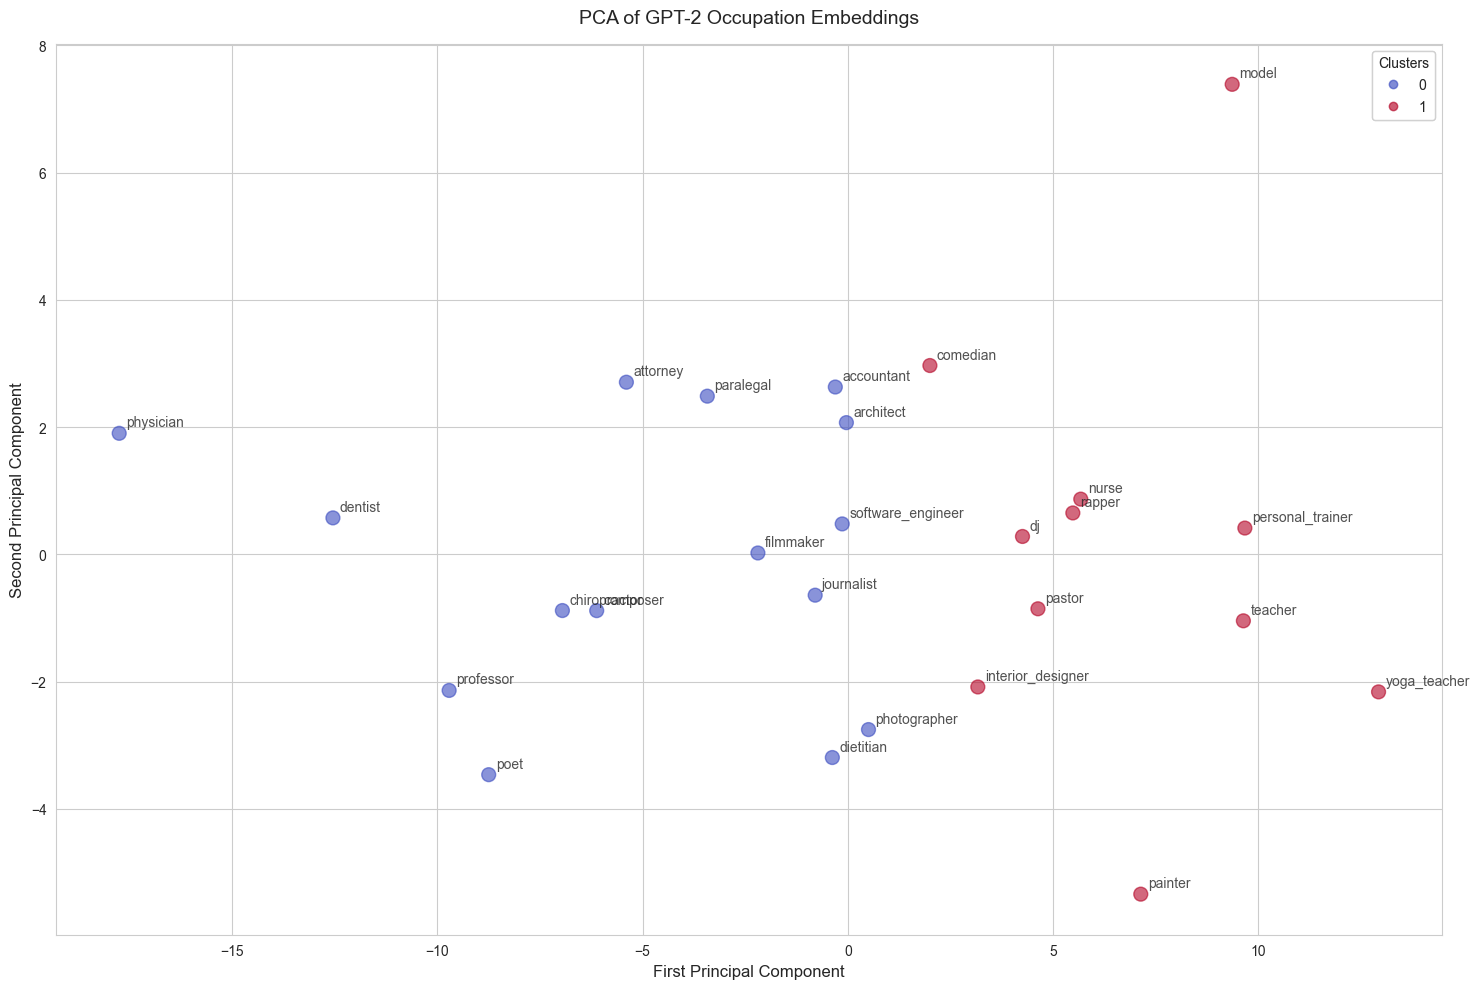

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 读取职业标签数据
prof_data = pd.read_csv('results/semantic_clustering_20250324/profession_bls_kmeans_comparison.csv')

# PCA降维
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embeddings)

# 设置绘图风格和大小
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# 创建散点图
scatter = plt.scatter(reduced[:,0], reduced[:,1], 
                     c=labels, 
                     cmap='coolwarm',
                     s=100,  # 增大点的大小
                     alpha=0.6)  # 设置透明度

# 添加职业标签
for i, occupation in enumerate(prof_data['occupation']):
    plt.annotate(occupation, 
                (reduced[i,0], reduced[i,1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                alpha=0.8)

# 设置标题和轴标签
plt.title('PCA of GPT-2 Occupation Embeddings', fontsize=14, pad=15)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)

# 添加图例
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Clusters",
                    loc="upper right")
plt.gca().add_artist(legend1)

# 调整布局
plt.tight_layout()

# 保存和显示
plt.savefig('results/semantic_clustering_20250324/pca_cluster.png', 
            dpi=300, 
            bbox_inches='tight')
plt.show()

In [18]:
print(prof_data['cluster'].value_counts())
print(prof_data.groupby('cluster')['bls_label'].value_counts())


cluster
0    18
1     8
Name: count, dtype: int64
cluster  bls_label               
0        neutral                     6
         female-stereotyped          5
         male-stereotyped            4
         neutral (proxy)             2
         male-stereotyped (proxy)    1
1        neutral                     5
         female-stereotyped          1
         male-stereotyped            1
         neutral (proxy)             1
Name: count, dtype: int64
